
# Tower A — Version 0 (Supervised, PINA)

This notebook connects data pipeline to **PINA** pipeline (Problem → Model → Solver → Trainer) 
Goal: a end-to-end training loop before we introduce PDE/physics (Tower A v1)

**What it does**
- Loads `dataset_tensors_v1_stim.npz` (X, y, cfg) 
- Defines a minimal `SupervisedProblem` in PINA (no physics).
- Trains a compact MLP to predict `lfp_response_rms` from the current/lfp features.
- Saves checkpoints & metrics to `data/results/towerA_v0/`.



In [1]:

# --- DELETE SHOULD B IN REQ ANYWAYSSetup ------------------------------------------------------------------
# If PINA isn't installed, uncomment ONE of these:
# !pip install pina
# or latest main:
# !pip install 'git+https://github.com/mathLab/PINA.git'
#
# (Make sure torch, numpy, pandas, matplotlib are available as well.)


In [2]:

import os, json, math, time, random, pathlib
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# PINA imports  
from pina import LabelTensor
from pina.problem.zoo.supervised_problem import SupervisedProblem
from pina.solver.supervised_solver.supervised import SupervisedSolver
from pina.trainer import Trainer
from pina import LabelTensor
from pina.optim.torch_optimizer import TorchOptimizer






# Reproducibility
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# Paths (repo-root aware). Edit if you need a different location.
REPO_ROOT = pathlib.Path.cwd().parents[0] if (pathlib.Path.cwd().name == 'notebooks') else pathlib.Path.cwd()
DATA_DIR   = REPO_ROOT / 'data'  # your symlink to OneDrive
OUT_DIR    = DATA_DIR / 'results' / 'towerA_v0'
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Repo root:", REPO_ROOT)
print("Data dir :", DATA_DIR)
print("Outputs  :", OUT_DIR)


Repo root: c:\Users\Melvi\02.1_Coding_projects\BME_Capstone_UH_2025\BME_Capstone_UH_2025_Github
Data dir : c:\Users\Melvi\02.1_Coding_projects\BME_Capstone_UH_2025\BME_Capstone_UH_2025_Github\data
Outputs  : c:\Users\Melvi\02.1_Coding_projects\BME_Capstone_UH_2025\BME_Capstone_UH_2025_Github\data\results\towerA_v0


In [3]:

# --- Load tensors ------------------------------------------------------------
# Expected file 
# Place the file under data/processed or point directly to the npz below.
candidate_paths = [
    DATA_DIR / 'processed' / 'Exp_1' / 'dataset_tensors_v0_all.npz',
]


npz_path = None
for p in candidate_paths:
    if p.exists():
        npz_path = p
        break

if npz_path is None:
    raise FileNotFoundError("Could not find dataset_tensors_v1_stim.npz in expected locations. "
                            "Please move it to data/processed/ or update paths above.")

data = np.load(npz_path)
X = data['X']   # shape [N, d_in]
y = data['y']   # shape [N, 1]
cfg = data.get('cfg', None)

print("Loaded:", npz_path)
print("X shape:", X.shape, "y shape:", y.shape, "cfg:", None if cfg is None else cfg.shape)

# Column names (match target_builder default order)
X_cols = ['stim_abs_max', 'stim_rms', 'lfp_baseline_rms'] if X.shape[1] == 3 else [f'x{i}' for i in range(X.shape[1])]

# Basic sanity
assert np.isfinite(X).all() and np.isfinite(y).all(), "Found NaNs/Inf in tensors."


Loaded: c:\Users\Melvi\02.1_Coding_projects\BME_Capstone_UH_2025\BME_Capstone_UH_2025_Github\data\processed\Exp_1\dataset_tensors_v0_all.npz
X shape: (105331, 1) y shape: (105331, 1) cfg: (105331,)


### Data Splitting and Normalization
shuffle all trial indices and then divide them into:
- **Training set (70%)** 
- **Validation set (15%)** 
- **Test set (15%)** 

** 2️ Normalization (Z-Score Standardization)**
To prevent large numeric ranges from dominating the learning process


In [4]:

# --- Split + normalization ---------------------------------------------------
N = X.shape[0]
idx = np.arange(N)
np.random.shuffle(idx)

train_frac, val_frac = 0.7, 0.15
n_train = int(N*train_frac)
n_val   = int(N*val_frac)
train_idx = idx[:n_train]
val_idx   = idx[n_train:n_train+n_val]
test_idx  = idx[n_train+n_val:]

X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

# z-score normalize inputs (fit on train, apply to all)
mean = X_train.mean(axis=0, keepdims=True)
std  = X_train.std(axis=0, keepdims=True) + 1e-8
Xn_train = (X_train - mean) / std
Xn_val   = (X_val   - mean) / std
Xn_test  = (X_test  - mean) / std

norm_meta = {'mean': mean.tolist(), 'std': std.tolist(), 'X_cols': X_cols}
with open(OUT_DIR / 'norm.json', 'w') as f:
    json.dump(norm_meta, f, indent=2)

print("Splits:", Xn_train.shape, Xn_val.shape, Xn_test.shape)


Splits: (73731, 1) (15799, 1) (15801, 1)


In [5]:

# --- Wrap in LabelTensor -----------------------------------------------------
    # PINA doesn’t just want plain tensors.... it wants LabelTensors(a PyTorch tensor with named dimensions.)

def to_label_tensor(x, names):
    t = torch.tensor(x, dtype=torch.float32)
    return LabelTensor(t, names) #Converts any numpy array x → torch.tensor.

    #labeled features for training:
X_lbl_train = to_label_tensor(Xn_train, X_cols) 
y_lbl_train = to_label_tensor(y_train, ['lfp_response_rms'])

    # labeled features for validation:
X_lbl_val = to_label_tensor(Xn_val, X_cols)
y_lbl_val = to_label_tensor(y_val, ['lfp_response_rms'])

    #labeled features for Testing:
X_lbl_test = to_label_tensor(Xn_test, X_cols)
y_lbl_test = to_label_tensor(y_test, ['lfp_response_rms'])



In PINA, every learning task is built around a Problem object
SupervisedProblem is the simplest subclass — it has no PDE or physics constraints, just data-driven supervision.

In [6]:
# --- Define and initialize TowerA_V0 ----------------------------------------
from pina.problem.zoo.supervised_problem import SupervisedProblem

# Initialize the problem with data only
problem = SupervisedProblem(
    input_ = X_lbl_train,
    output_ = y_lbl_train
)

# EXPLICITLY attach variable names 
problem.input_variables  = X_cols
problem.output_variables = ['lfp_response_rms']

# Optionally add validation set
if hasattr(problem, "add_dataset"):
    problem.add_dataset(
        name='val',
        input_data=X_lbl_val,
        output_data=y_lbl_val
    )

print("Problem defined.")
print("Inputs:", problem.input_variables)
print("Outputs:", problem.output_variables)




Problem defined.
Inputs: ['x0']
Outputs: ['lfp_response_rms']


In [7]:

# --- Model/Solver/Trainer ----------------------------------------------------
# Define a small MLP in plain torch (PINA accept torch.nn.Modules)
import torch.nn as nn
    # Core neural network Definition:
class MLP(nn.Module):               #Multi-Layer Perceptron 
    def __init__(self, d_in, d_hid=32, d_out=1): #defines the MLP’s structure:
        super().__init__()          #calls the parent
        self.net = nn.Sequential(   #builds a stack of layers that data flows through in order.
            nn.Linear(d_in, d_hid), #mapping from a inputs to b outputs.
            nn.ReLU(),              #replaces negatives with 0) to introduce nonlinearity.
            nn.Linear(d_hid, d_hid),
            nn.ReLU(),
            nn.Linear(d_hid, d_out),
        )
    def forward(self, x):          #Defines how input → output flows
        return self.net(x)

# Instantiate model
model = MLP(d_in=Xn_train.shape[1], d_hid=64, d_out=1)

# ✅ Pass problem as first argument
solver = SupervisedSolver(
    problem = problem,
    model = model,
    optimizer = TorchOptimizer(torch.optim.Adam, lr=1e-3)
)


# Trainer setup
trainer = Trainer(
    solver  = solver,
    max_epochs = 200,
    batch_size = 512
)



# Train the model
trainer.train()

# Save the model weights manually
torch.save(model.state_dict(), OUT_DIR / 'towerA_v0_model.pt')

print("✅ Training complete and model saved to:", OUT_DIR)



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\Melvi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
C:\Users\Melvi\AppData\Local\Packages\PythonSoftwar

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


✅ Training complete and model saved to: c:\Users\Melvi\02.1_Coding_projects\BME_Capstone_UH_2025\BME_Capstone_UH_2025_Github\data\results\towerA_v0


R² (validation): 0.076
R² (test):       0.088
⚠️  Trainer had no logger or history — skipping loss plot.


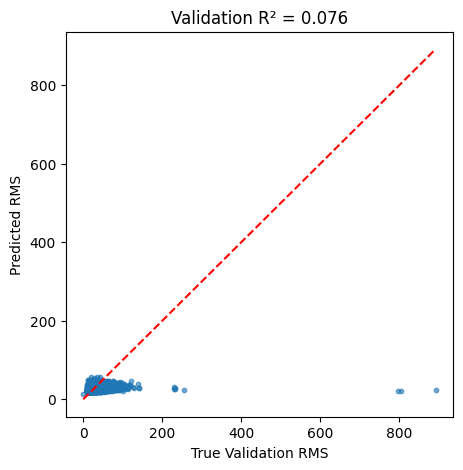

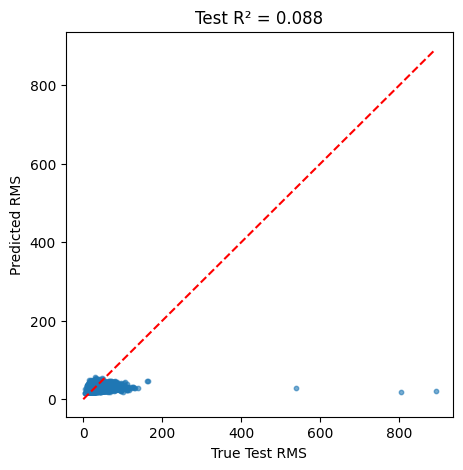

✅ Saved predictions and figures to: c:\Users\Melvi\02.1_Coding_projects\BME_Capstone_UH_2025\BME_Capstone_UH_2025_Github\data\results\towerA_v0


In [8]:
# --- Evaluation --------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import torch

model.eval()
with torch.no_grad():
    yhat_val  = model(X_lbl_val.tensor).cpu().numpy()
    yhat_test = model(X_lbl_test.tensor).cpu().numpy()

# --- R² metrics --------------------------------------------------------------
def r2_score(y_true, y_pred):
    y_true = y_true.squeeze(); y_pred = y_pred.squeeze()
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - y_true.mean())**2) + 1e-12
    return 1.0 - ss_res/ss_tot

r2_val  = r2_score(y_val,  yhat_val)
r2_test = r2_score(y_test, yhat_test)
print(f"R² (validation): {r2_val:.3f}")
print(f"R² (test):       {r2_test:.3f}")

# --- Optional: try to pull loss curves from logger ----------------------------
metrics = getattr(trainer.solver, "logger", None)
if metrics is not None and hasattr(metrics, "history"):
    hist = metrics.history
    if "epoch" in hist and "train_loss" in hist:
        plt.figure(figsize=(6,4))
        plt.plot(hist["epoch"], hist["train_loss"], label="Train Loss")
        if "val_loss" in hist:
            plt.plot(hist["epoch"], hist["val_loss"], label="Val Loss")
        plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend()
        plt.title("Tower A v0 — Learning Curve")
        plt.show()
    else:
        print("⚠️  No train/val loss history found in logger.")
else:
    print("⚠️  Trainer had no logger or history — skipping loss plot.")

# --- Scatter: predicted vs true ---------------------------------------------
plt.figure(figsize=(5,5))
plt.scatter(y_val, yhat_val, s=10, alpha=0.6)
m = max(float(y_val.max()), float(yhat_val.max()))
plt.plot([0,m],[0,m],'r--')
plt.xlabel("True Validation RMS")
plt.ylabel("Predicted RMS")
plt.title(f"Validation R² = {r2_val:.3f}")
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(y_test, yhat_test, s=10, alpha=0.6)
m = max(float(y_test.max()), float(yhat_test.max()))
plt.plot([0,m],[0,m],'r--')
plt.xlabel("True Test RMS")
plt.ylabel("Predicted RMS")
plt.title(f"Test R² = {r2_test:.3f}")
plt.show()

# --- Save predictions --------------------------------------------------------
np.savez(
    OUT_DIR / "predictions_v0.npz",
    y_val=y_val, yhat_val=yhat_val,
    y_test=y_test, yhat_test=yhat_test,
    r2_val=r2_val, r2_test=r2_test
)
print("✅ Saved predictions and figures to:", OUT_DIR)

